In [60]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [20]:
df = pd.read_csv("../../data/v0_2.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string"))

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")

In [ ]:
df2 = df[(df.BeginISODate+df.EndISODate) > 0]

df2.apply(lambda r: len(str(r.Title) + str(r.Description)) > 6, axis="columns").sum()/df2.shape[0]

In [ ]:
type(df2.iloc[0].Description)

In [ ]:

import spacy
from nltk import Tree

nlp = spacy.load("nl_core_news_sm")

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
    
doc = nlp(df.Description.dropna().iloc[0])
print(doc)
[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

In [ ]:
from spacy import displacy
displacy.render(doc, style='dep')

In [ ]:
[nlp(t) for t in tqdm(df.Description) if isinstance(t, str)]

---
# Search

In [ ]:
kws = "" # "hello, goodbye"
prep_kws = "|".join(kws.lower().replace(", ", ",").split(","))
        
if (not kws.strip()) or (not prep_kws):
    does_contain = [True]*df.shape[0]
else:
    print("what")
    
print(does_contain)

In [ ]:
from urllib.parse import unquote

unquote('"objectKeywords"%3A""%2C"objectStartDate"%3A""%2C"objectEndDate"')

---
# Dates

 1. make all dates at least 1 (because python cannot deal with years <= 0)  
    (or drop non-positive dates)  
    (drop objects with EndISODate <= 0 in any case (doesn't make any sense))  
 
 2. convert all year values to %Y-%m-%d format (expected by Werner's API)  
    (by using datetime.strptime; allows comparison with > )  

In [ ]:
from datetime import datetime
frmt = "%Y-%m-%d"
start_year, end_year = datetime.strptime("2011-02-01", frmt), datetime.strptime("2013-10-02", frmt)

In [ ]:
(start_year.year > df.BeginISODate).sum()

In [ ]:
df.BeginISODate[(df.BeginISODate > 1500)].hist(bins=100)

### 1.

In [ ]:
df = df[df.EndISODate > 0]

# drop
df = df[df.BeginISODate > 0]

# change
df["BeginISODate"] = df.BeginISODate.replace(0, 1)

### 2.

In [ ]:
df["start_date"] = df.BeginISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))
df["end_date"] = df.EndISODate.astype(str).str.zfill(4).apply(lambda s: dt.strptime(s, "%Y"))

---
# Fixing Strange x-Axis Data Issue 

In [ ]:
https://sabio.diginfra.nl/api/v1/objects/<datasetID>/search/%7B%22objectKeywords%22%3A%22hengelo%22%2C%22objectStartDate%22%3A%22%22%2C%22objectEndDate%22%3A%22%22%2C%22objectParams%22%3A[%7B%22id%22%3A%22Classification%22%2C%22value%22%3A%22%22%7D%2C%7B%22id%22%3A%22Department%22%2C%22value%22%3A%22%22%7D]%2C%22engineId%22%3A%22RandomEnginev0%22%2C%22engineMinScore%22%3A0%2C%22engineMaxScore%22%3A1%2C%22engineParams%22%3A[%7B%22id%22%3A0%2C%22value%22%3A%22useless1%22%7D]%2C%22vocabularyTerms%22%3A%22bewindhebber%2Cbewindvoerder%2Cbomba%2Cbombay%2Ccimarron%2Cderde%20wereld%2Cdwerg%2Cexpeditie%2Cgouverneur%2Chalfbloed%2Chottentot%2Cinboorling%2Cindiaan%2Cindisch%2Cindo%2Cinheems%2Cinlander%2Cjap%2Cjappen%2Cjappenkampen%2Ckaffer%2Ckaffir%2Ckafir%2Ckoelie%2Ckolonie%2Clagelonenland%2Clandhuis%2Cmarron%2Cmarronage%2Cmissie%2Cmissionaris%2Cmoor%2Cmoors%2Cmoren%2Cmulat%2Coctroon%2Contdekken%2Contdekking%2Contdekkingsreis%2Contwikkelingsland%2Coorspronkelijk%2Coosters%2Copperhoofd%2Cori%C3%ABntaals%2Cpinda%2Cpolitionele%20actie%2Cprimitief%2Cprimitieven%2Cpygmee%2Cras%2Crasch%2Cslaaf%2Cstam%2Cstamhoofd%2Ctraditioneel%2Ctropisch%2Cwesters%2Cwilden%2Czendeling%2Czendelingen%2Czending%22%7D/scatterplot/1/405100?api=https%3A%2F%2Fsabio.diginfra.net%2Fapi%2Fv1%2F

In [ ]:
https://sabio.diginfra.nl/api/v1/engines

In [ ]:
https://sabio.diginfra.net/api/v1/objects/NMvW_v0/search?object_keywords=hengelo&object_start_date=&object_end_date=&engine_id=RandomEnginev0&engine_min_score=0&engine_max_score=1&vocabulary_terms=bewindhebber%2Cbewindvoerder%2Cbomba%2Cbombay%2Ccimarron%2Cderde%20wereld%2Cdwerg%2Cexpeditie%2Cgouverneur%2Chalfbloed%2Chottentot%2Cinboorling%2Cindiaan%2Cindisch%2Cindo%2Cinheems%2Cinlander%2Cjap%2Cjappen%2Cjappenkampen%2Ckaffer%2Ckaffir%2Ckafir%2Ckoelie%2Ckolonie%2Clagelonenland%2Clandhuis%2Cmarron%2Cmarronage%2Cmissie%2Cmissionaris%2Cmoor%2Cmoors%2Cmoren%2Cmulat%2Coctroon%2Contdekken%2Contdekking%2Contdekkingsreis%2Contwikkelingsland%2Coorspronkelijk%2Coosters%2Copperhoofd%2Cori%C3%ABntaals%2Cpinda%2Cpolitionele%20actie%2Cprimitief%2Cprimitieven%2Cpygmee%2Cras%2Crasch%2Cslaaf%2Cstam%2Cstamhoofd%2Ctraditioneel%2Ctropisch%2Cwesters%2Cwilden%2Czendeling%2Czendelingen%2Czending&object_param_Classification=&object_param_Department=&engine_param_0=useless1

---

In [ ]:
from src.results import Result

In [ ]:
param_names = ["Department", "Classification"]

In [ ]:
attributes = ["BeginISODate", "EndISODate"] 
attributes = attributes + param_names

In [ ]:
df[attributes]

In [ ]:
values = df[attributes]

In [ ]:
r = Result(param_names=param_names, rows=df, scores=np.zeros(len(df)), 
                 score_details=df, min_score=0., max_score=1.)

In [ ]:
r.values

---
# Keyword Search Dev

In [ ]:
kws = "Maarten Sint"
prep_kws = "|".join(kws.lower().replace(", ", ",").split(","))

In [ ]:
prep_kws

In [ ]:
d = dict(a=)

d.get("a", False)

In [ ]:
def f(**kwargs):
    print(kwargs)
    
    
d = dict(a=13)
f(a=0, **d)

---
# Integrating TypicalityEngine

In [ ]:
from src.datasets import NMvW
from src.engines.TypicalityEnginev0 import Typicality, TypicalityEngine

NMvW.data = NMvW.data.iloc[:10000]

In [ ]:
typE = TypicalityEngine(id_="TypicalityEnginev0",
                           name="TypicalityEngine/v0",
                           dataset=NMvW,
                           params=[],
                       from_saved=False)

In [ ]:
texts = NMvW.data.sample(frac=0.3).fillna("")

typs, details = typE.score_and_detail(texts)

In [ ]:
import seaborn as sns
sns.histplot(typs, color="blue")

In [ ]:
details.iloc[-1]

In [ ]:
import joblib
joblib.dump(typE.typicality, "test.pkl")

In [ ]:
import joblib
joblib.dump(typE, "test.pkl")

---

In [ ]:
import joblib
typ2 = joblib.load("test.pkl")

In [ ]:
texts = NMvW.data.sample(frac=0.3).fillna("")
typs2, details2 = typ2.score_and_detail(texts)

In [ ]:
typs, details = typE.score_and_detail(texts)

In [ ]:
(typs == typs2)

# Fast Iteration over Results

In [ ]:
df = pd.read_csv("../../data/v0_2.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string"))

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")

In [ ]:
ids = df.index.astype("string")
titles = df.Title.fillna("").astype("string")
thumbnails = pd.Series([""]*df.shape[0], 
                       name="Thumbnail",
                      index=df.index).astype("string")

In [ ]:
r = pd.concat([titles, thumbnails], axis=1)
r.index, ids

In [ ]:
r#.astype("string")

In [ ]:
lens = []
for i, row in tqdm(r.to_dict("index").items()):
    lens.append(sum(map(len, row.values())))

In [ ]:
lens = []
for i in tqdm(range(r.shape[0])):
    lens.append(sum(map(len, r.iloc[i])))

In [ ]:
r_ = r.apply(lambda col: col.str.replace(" ", "X"), axis=0)
r_.columns = [c + "X" for c in r_.columns]
r2 = pd.concat([r, r_], axis=1)

In [ ]:
t = pd.Series(np.random.random(size=df.shape[0]), index=df.index)

In [ ]:
t.iloc[0].round(3)

# TypicalityEngine Value Range

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
scores = pd.read_csv("/home/valentin/Desktop/scores.csv").set_index("ObjectID")["score"]
score_details = pd.read_csv("/home/valentin/Desktop/score_details.csv").set_index("ObjectID")

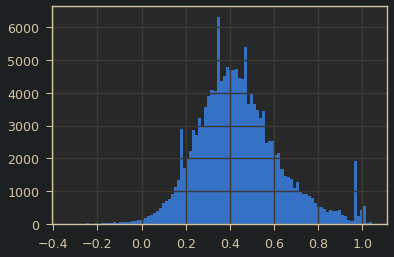

In [5]:
_=plt.hist(scores, bins=100)
# _=plt.hist((1/scores)-1, bins=100)

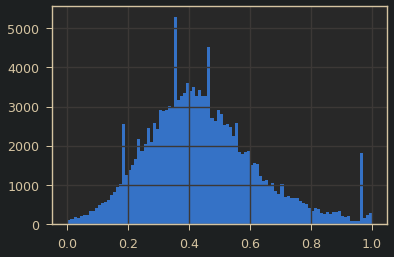

In [17]:
(scores < 100).sum()/scores.shape[0]

_= plt.hist(scores[(scores > 0) & (scores < 1)], bins=100)
# plt.xlim((0.95, 0.98))

In [37]:
df.loc[.index]

,DepartmentID,ClassificationID,ObjectName,Medium,Provenance,Exhibitions,BeginISODate,EndISODate,Dated,Title,Description,Notes,CuratorialRemarks,RelatedWorks,HistAttributions,Classification,AATCN,SubClassification,Department
ObjectID,,,,,,,,,,,,,,,,,,,
5,0,156.0,NaN,NaN,<NA>,NaN,1850-01-01,1958-01-01,voor 1958,?,NaN,NaN,NaN,<NA>,NaN,Materiële cultuurcollectie,Voorwerpen,NaN,(niet toegekend)
2014,3,148.0,NaN,NaN,<NA>,NaN,1900-01-01,1940-01-01,1900-1940,NaN,NaN,NaN,NaN,<NA>,NaN,Audiovisuele collectie,Foto's,Foto's,Insulair Zuidoost-Azië
2737,3,148.0,Foto,NaN,<NA>,NaN,1900-01-01,1940-01-01,1900 - 1940,NaN,NaN,Foto afkomstig uit Portefeuille Oudheidkundige...,NaN,<NA>,NaN,Audiovisuele collectie,Foto's,Foto's,Insulair Zuidoost-Azië
587176,1,156.0,vuurpen,NaN,<NA>,NaN,1800-01-01,1829-01-01,1800-1829,NaN,NaN,NaN,NaN,<NA>,NaN,Materiële cultuurcollectie,Voorwerpen,NaN,Japan en Korea
585656,1,156.0,eetstokje (stel),hout,<NA>,NaN,1800-01-01,1829-01-01,1800-1829,NaN,NaN,NaN,NaN,<NA>,NaN,Materiële cultuurcollectie,Voorwerpen,NaN,Japan en Korea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137774,3,156.0,paardenhalsband,"paardenhaar, plantenvezel, katoen, rotan (?)","Bruikleen 23-02-1914 Payeti *[nT], Sumba. De ...",Geweven wereld: ikats van Sumba ; Museum voor ...,1900-01-01,1925-01-01,begin 20e eeuw,NaN,NaN,NaN,NaN,<NA>,NaN,Materiële cultuurcollectie,Voorwerpen,NaN,Insulair Zuidoost-Azië
1137775,3,156.0,paardenhoofdtuig,"plantenvezel, rotan, hout","Bruikleen 23-02-1914 Payeti *[nT], Sumba. De ...",Geweven wereld: ikats van Sumba ; Museum voor ...,1900-01-01,1925-01-01,begin 20e eeuw,NaN,NaN,NaN,NaN,<NA>,NaN,Materiële cultuurcollectie,Voorwerpen,NaN,Insulair Zuidoost-Azië
1138074,3,161.0,jas,"importwol, glas, importkatoen",<NA>,Cultuurontmoeting in textiel ; Wereldmuseum Ro...,1890-01-01,1915-01-01,1890-1915,NaN,NaN,NaN,NaN,<NA>,NaN,Materiële cultuurcollectie,Textiel,Textiel,Insulair Zuidoost-Azië


In [38]:
(df.fillna("").loc[scores[scores.between(0.96, 0.97)].index].Title.str.len() > 10)

ObjectID
5          False
2014       False
2737       False
587176     False
585656     False
           ...  
1137774    False
1137775    False
1138074    False
1149512    False
1139036    False
Name: Title, Length: 1823, dtype: bool

In [ ]:
unnormed = (1/scores)-1

sns.histplot(unnormed.abs())

In [ ]:
plt.plot(1/(np.linspace(0., 10000., 1000)+1)**2)
plt.plot(1/(np.linspace(0., 10000., 1000)+1)**0.5)

plt.plot(1/np.log(np.linspace(0., 10000., 1000)+1))
# plt.plot(np.linspace(0., 1000., 1000)/(np.linspace(0., 1000., 1000).sum()))

# plt.ylim((0, 1))

In [ ]:
plt.hist(1/(unnormed.abs()+1))

In [ ]:
z = (unnormed - unnormed.mean())/(unnormed.var()**0.5)

sns.histplot(z)

In [ ]:
# unnormed = scores

def norm(v):
    return (v - v.min())/(v.max() - v.min())

normed = np.log(norm(norm(unnormed))+1)

sns.histplot(normed)

# Search Parameters

In [55]:
df.AATCN.str.replace(" (doc.)", "", regex=False).value_counts()

Foto's               66302
Voorwerpen           28974
Negatieven           11267
Textiel               5678
Archeologica          5406
Drukwerk              5339
Dia’s                 4623
Documentatie TXT      2944
Dia's                 2862
Prentbriefkaarten     2761
Schilderingen         1976
Albums                1746
Beeldcollectie        1488
Tekeningen            1103
TT-elementen          1052
Verzamelingen          750
Naturalia              525
Lichtbeelden           375
Tijdelijk nummer       363
Boeken                 290
Film                   233
Documenten             199
Rekwisieten            183
Antropologica          104
(niet in gebruik)       78
Documentatie AV         58
(niet ingevoerd)         8
Documentatie             7
Name: AATCN, dtype: int64

---
# ContentLengthEngine Dev

In [62]:
lengths = df.fillna("").progress_apply(lambda r: len(r.Title) + len(r.Description), axis="columns")

100%|████████████████████████████████████████████████████████████████████| 146694/146694 [00:03<00:00, 46776.83it/s]


(-0.4, 1.0)

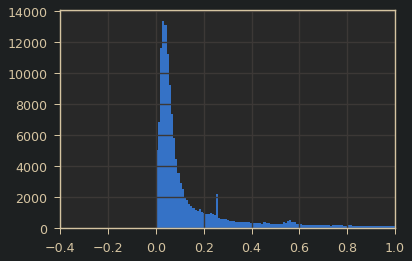

In [117]:
_=plt.hist(lengths/1000, bins=5000)
plt.xlim((-0.4, 1.))

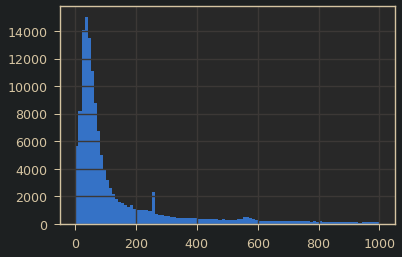

In [109]:
_= plt.hist((lengths[lengths.between(0, 1000)]+1), bins=100)

(0.8, 1.0)

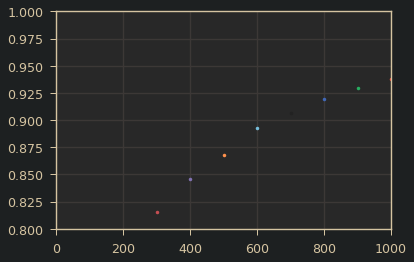

In [111]:
for m in np.linspace(100, 20000, 200):
    plt.plot([m], [lengths[lengths.between(0, m)].shape[0]/lengths.shape[0]], ".")
    
plt.xlim((0, 1000))
plt.ylim((0.8, 1.0))

In [134]:
from src.engines.ContentLengthEnginev0 import ContentLengthEngine

cl_eng = ContentLengthEngine(id_="ContentLengthEnginev0",
                            name="ContentLengthEngine/v0",
                            dataset=df,
                            params=[])

100%|████████████████████████████████████████████████████████████████████| 146694/146694 [00:03<00:00, 42037.63it/s]


In [124]:
scores, details = cl_eng.score_and_detail(df)
scores = scores/cl_eng.max_len

(-0.1, 1.0)

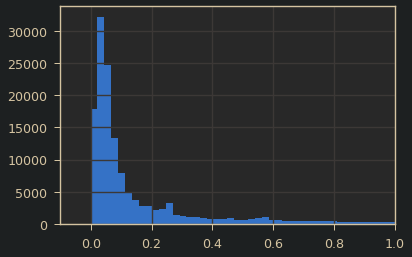

In [129]:
scores.hist(bins=2000)
plt.xlim((-0.1, 1.))

In [133]:
scores

ObjectID
2          0.006
5          0.001
8          0.004
9          0.009
10         0.022
           ...  
1140385    0.089
1140386    0.051
1140388    0.167
1140389    0.025
1153236    0.087
Name: score, Length: 146694, dtype: float64

In [135]:
df.progress_apply(lambda r: len(r), axis="columns", desc="somthing")

  0%|                                                                          | 1/146694 [00:00<3:01:03, 13.50it/s]


TypeError: <lambda>() got an unexpected keyword argument 'desc'